# Projeto EDA - Módulo de Estatística - Ada Tech
### Analisando um dataset relacionado a nascimentos ao longo dos anos nos EUA

In [ ]:
#importando as biblioteca pandas e abrindo o arquivo .csv

import pandas as pd
births = pd.read_csv("births.csv")
print(births.head())

   year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548


In [ ]:
births.rename(columns={'year': 'ano', 'month': 'mes', 'day': 'dia', 'gender': 'genero', 'births': 'nascimentos'}, inplace=True)

In [ ]:
print(births.head())

    ano  mes  dia genero  nascimentos
0  1969    1  1.0      F         4046
1  1969    1  1.0      M         4440
2  1969    1  2.0      F         4454
3  1969    1  2.0      M         4548
4  1969    1  3.0      F         4548


In [ ]:
# Aqui fazemos os primeiros tratamentos, substituindo valores nulos por 0, e transformando a coluna 'day' em variáveis inteiras
births['dia'].fillna(0, inplace=True)
births['dia'] = births['dia'].astype(int)

In [ ]:
# Agora vamos criar uma coluna 'decada', que descreve a década correspondente ao ano informado
births['decada'] = 10 * (births['ano'] // 10)
births.pivot_table('nascimentos', index='decada', columns='genero', aggfunc='sum')
print(births.head())

    ano  mes  dia genero  nascimentos  decada
0  1969    1    1      F         4046    1960
1  1969    1    1      M         4440    1960
2  1969    1    2      F         4454    1960
3  1969    1    2      M         4548    1960
4  1969    1    3      F         4548    1960


In [ ]:
# Aqui criamos uma pivot table com a quantidade acumulada de número de nascimentos
births.pivot_table('nascimentos', index='decada', columns='genero', aggfunc='sum')
print(births.pivot_table)

<bound method DataFrame.pivot_table of         ano  mes  dia genero  nascimentos  decada
0      1969    1    1      F         4046    1960
1      1969    1    1      M         4440    1960
2      1969    1    2      F         4454    1960
3      1969    1    2      M         4548    1960
4      1969    1    3      F         4548    1960
...     ...  ...  ...    ...          ...     ...
15542  2008   10    0      M       183219    2000
15543  2008   11    0      F       158939    2000
15544  2008   11    0      M       165468    2000
15545  2008   12    0      F       173215    2000
15546  2008   12    0      M       181235    2000

[15547 rows x 6 columns]>


Aparentemente os nascimentos masculinos superam os nascimentos femininos.
Podemos então plotar um gráfico e analisar essa tendência:

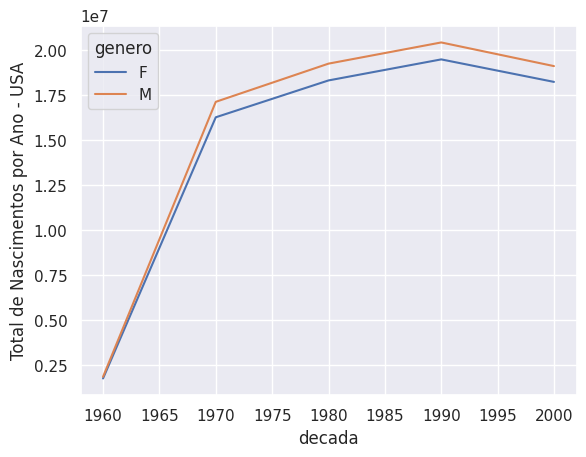

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
birth_decada = births.pivot_table('nascimentos', index='decada', columns='genero', aggfunc='sum')
birth_decada.plot()
plt.ylabel("Total de Nascimentos por Ano - USA")
plt.show()

Podemos obter mais análises interessantes com esses dados, usando as ferramentas da bibloteca pandas. Precisamos começar a análise mais profunda eliminando os outliers que foram causados por erros de digitação, etc. Para fazer isso de uma maneira eficiente e rápida, podemos eliminar os outliers usando 'sigma-clipping'.

In [ ]:
import numpy as np
quartiles = np.percentile(births['nascimentos'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

A última linha é uma estimativa robusta da média da amostra, e o valor de 0.74 vem da diferença dos quartis da distribuição normal. Com isso podemos usar o seguinte método pra filtrar nascimentos fora desses intervalos.

In [ ]:
births = births.query('(nascimentos > @mu - 5 * @sig) & (nascimentos < @mu + 5 * @sig)')
births['dia'] = births['dia'].astype(int)
births.index = pd.to_datetime(10000 * births.ano +
                              100 * births.mes +
                              births.dia, format='%Y%m%d')

births['diadasemana'] = births.index.dayofweek
print(births)

<ipython-input-54-415ade185062>:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])


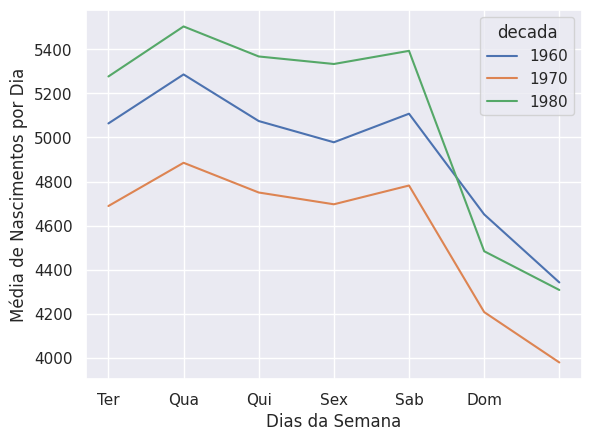

In [ ]:
births.pivot_table('nascimentos', index='diadasemana', columns='decada', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
plt.xlabel('Dias da Semana')
plt.ylabel('Média de Nascimentos por Dia');
plt.show()

Obs 1: Nota-se que o índice de nascimentos em dias de semana é maior do que nos fins de semana.
Obs 2: Não podemos analisar as décadas de 90 e 00 porque os dados registrados a partir de 1989 só contem o mes de nascimento.

Outra visualização interessante é a de número de nascimentos por dia do ano. Pra isso, precisamos agrupar os dados por dia e mês separadamente.

In [ ]:
births_month = births.pivot_table('nascimentos', [births.index.month, births.index.day])
print(births_month.head())

births_month.index = [pd.datetime(2012, month, day)
                      for (month, day) in births_month.index]
print(births_month.head())

     nascimentos
1 1     4009.225
  2     4247.400
  3     4500.900
  4     4571.350
  5     4603.625
            nascimentos
2012-01-01     4009.225
2012-01-02     4247.400
2012-01-03     4500.900
2012-01-04     4571.350
2012-01-05     4603.625


<ipython-input-56-3471de198c8a>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  births_month.index = [pd.datetime(2012, month, day)


Se focarmos apenas no mês e dia, temos uma série temporal que reflete o número médio de nascimentos por data no ano. Plotando esses dados vemos tendências interessantes:


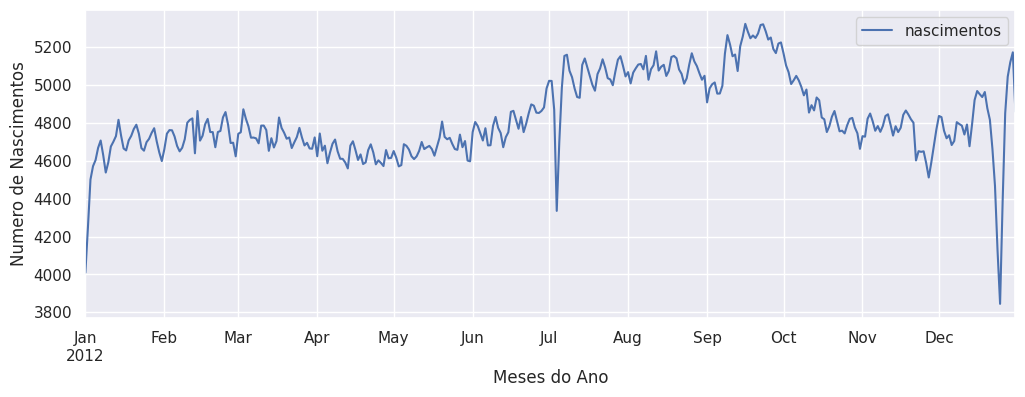

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
births_month.plot(ax=ax)
plt.xlabel('Meses do Ano')
plt.ylabel('Numero de Nascimentos')
plt.show()

Observamos que ao longo do ano o número de nascimentos varia bastante, existindo uma maior taxa de natalidade nos períodos de Julho a Outubro, verão no hemisfério Norte.